# Load and test pre-trained models

Load and test Tb + Emiss models and check the correlation between GSI for IGBP and the error of the model. (Heterogeneity vs mse)



In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from matplotlib.colors import CenteredNorm, LogNorm
from matplotlib.cm import ScalarMappable
from tensorflow.keras.models import load_model

import xarray as xr
import pandas as pd
import numpy as np

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__name__), '../..')))

from src.processing import windsat_datacube, model_preprocess, telsem_datacube, doy2month_mapping
from src.model import plot_history, xy_split

models_path = "../../models/"
GSI_path = "../../data/processed/igbp_GSI_wsgrid.h5"
telsem_folder = r"..\..\data\processed\WindsatEmiss"

# Select ascending (0) or descending (1) pass
swath2name = {
    0 : "Asc",
    1 : "Des"
}

# Define / load the models

regressions = { # Swath : (a,b)
    0 : (0.56, 138.29),
    1 : (0.54 , 142.98)
}

model_folder = "..\..\models"

modelsv1 = {
    0 : load_model(os.path.join(model_folder, "WSMv1_A_2024_07_23T135732" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv1_D_2024_07_23T120006" + ".keras")),
}

modelsv2 = {
    0 : load_model(os.path.join(model_folder, "WSMv2_A_2024_07_23T202640" + ".keras")),
    1 : load_model(os.path.join(model_folder, "WSMv2_D_2024_07_23T180208" + ".keras")),
}

In [2]:
# Preprocessing of TELSEM atlas:
telsem_ds = telsem_datacube(telsem_folder)
telsem_df = telsem_ds.to_dataframe().dropna().reset_index("month")


In [2]:
# Load Gini-Simpson Index and see how the error correlates with it
gsi_ds = xr.open_dataarray(GSI_path, engine="h5netcdf")
gsi_ds

<xarray.DataArray 'Land_Cover_Type_1_Percent' (y: 720, x: 1440)> Size: 4MB
[1036800 values with dtype=float32]
Coordinates:
    spatial_ref  int32 4B ...
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes:
    long_name:    Gini-Simpson Index
    units:        dimensionless
    description:  Index describing diversity or dominance of land cover types

In [6]:
# WINDSAT data
folder_path = "../../data/raw/Daily_Windsat/"
ds = windsat_datacube(folder_path)

# Add the GSI to the windsat dataset:
ds["GSI"] = (("latitude_grid","longitude_grid"), gsi_ds.values)

In [13]:
combined_df.columns

Index(['surtep_ERA5', 'lat', 'lon', 'tbtoa_18Ghz_V', 'tbtoa_18Ghz_H',
       'tbtoa_37Ghz_V', 'tbtoa_37Ghz_H', 'surtep_LINEAR', 'linear_error',
       'Emis19V', 'Emis19H', 'Emis37V', 'Emis37H'],
      dtype='object')

In [25]:
def get_swath_data(swath: int, ds:xr.Dataset):

    swath_ds= model_preprocess(ds, swath_sector=swath, look="impute", add_look_flag=False)
    swath_ds["GSI"] = (("latitude_grid","longitude_grid"), gsi_ds.values)
    # Linear model predictions:
    a, b =regressions[swath]

    swath_ds["surtep_LINEAR"] = a * swath_ds.tbtoa_37Ghz_V + b
    swath_ds["linear_error"] = swath_ds.surtep_LINEAR - swath_ds.surtep_ERA5

    # Transformations to dataframe
    swath_df = swath_ds.to_dataframe().dropna().reset_index("day_number")

    day_mapping = doy2month_mapping()

    swath_df["month"] = swath_df["day_number"].apply(lambda x: day_mapping[x])
    # drop the day_number column
    swath_df = swath_df.drop(columns="day_number")

    # Inner join the telsem df and the ascending df
    combined_df = pd.merge(left=swath_df, right=telsem_df, how="inner")

    # Drop the month column
    combined_df = combined_df.drop(columns="month")

    # Lat-lon transformations
    combined_df["lon"] = combined_df["lon"].apply(lambda x: np.sin(np.deg2rad(x)))
    combined_df["lat"] = combined_df["lat"].apply(lambda x: np.sin(np.deg2rad(x)))

    ## MODEL v1
    modelv1 = modelsv1[swath]
    # Select the variables from windsat that we need:

    Mv1_d_vars = [
        "surtep_ERA5",
        "lat",
        "lon",
        "tbtoa_18Ghz_V",
        "tbtoa_18Ghz_H",
        "tbtoa_37Ghz_V",
        "tbtoa_37Ghz_H",
    ]

    v1_df = combined_df[Mv1_d_vars]


    # Predict for the local sample and plot:
    X, y = xy_split(v1_df, y_column = "surtep_ERA5")
    combined_df["surtep_MODELv1"] = modelv1.predict(X)
    combined_df["errorv1"] =  combined_df["surtep_MODELv1"] - combined_df["surtep_ERA5"]


    ## MODEL v2
    modelv2 = modelsv2[swath]

    Mv2_d_vars = [
        "surtep_ERA5",
        "lat",
        "lon",
        "tbtoa_18Ghz_V",
        "tbtoa_18Ghz_H",
        "tbtoa_37Ghz_V",
        "tbtoa_37Ghz_H",
        'Emis19V',
        'Emis19H',
        'Emis37V',
        'Emis37H',
    ]

    v2_df = combined_df[Mv2_d_vars]

    # Predict for the local sample and plot:
    X, y = xy_split(v2_df, y_column = "surtep_ERA5")
    combined_df["surtep_MODELv2"] = modelv2.predict(X)
    combined_df["errorv2"] =  combined_df["surtep_MODELv2"] - combined_df["surtep_ERA5"]

    # Get all the errors to plot later
    errors_df = combined_df[["GSI","linear_error","errorv1","errorv2"]]

    return errors_df

In [26]:
# iterate for both swaths:

swath_error_list = []
for swath, _ in swath2name.items():
    swath_error_list.append(get_swath_data(swath, ds=ds))

    

True
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 40s 766us/step
52364/52364 ━━━━━━━━━━━━━━━━━━━━ 33s 635us/step
True
40291/40291 ━━━━━━━━━━━━━━━━━━━━ 31s 754us/step
40291/40291 ━━━━━━━━━━━━━━━━━━━━ 34s 846us/step


In [56]:
swath_corr_list = []
for i, swath_errors_df in enumerate(swath_error_list):
    swath_corr = swath_error_list[i].corr()
    print(swath_corr["GSI"][1:])
    swath_corr_list.append(swath_corr["GSI"][1:])



linear_error    0.007483
errorv1         0.020687
errorv2        -0.013798
Name: GSI, dtype: float64
linear_error   -0.141615
errorv1         0.001727
errorv2        -0.005946
Name: GSI, dtype: float64


In [65]:
gsi_corrs = pd.DataFrame({
    "Asc" : swath_corr_list[0],
    "Des" : swath_corr_list[1]
})
print(gsi_corrs.to_latex())

\begin{tabular}{lrr}
\toprule
 & Asc & Des \\
\midrule
linear_error & 0.007483 & -0.141615 \\
errorv1 & 0.020687 & 0.001727 \\
errorv2 & -0.013798 & -0.005946 \\
\bottomrule
\end{tabular}



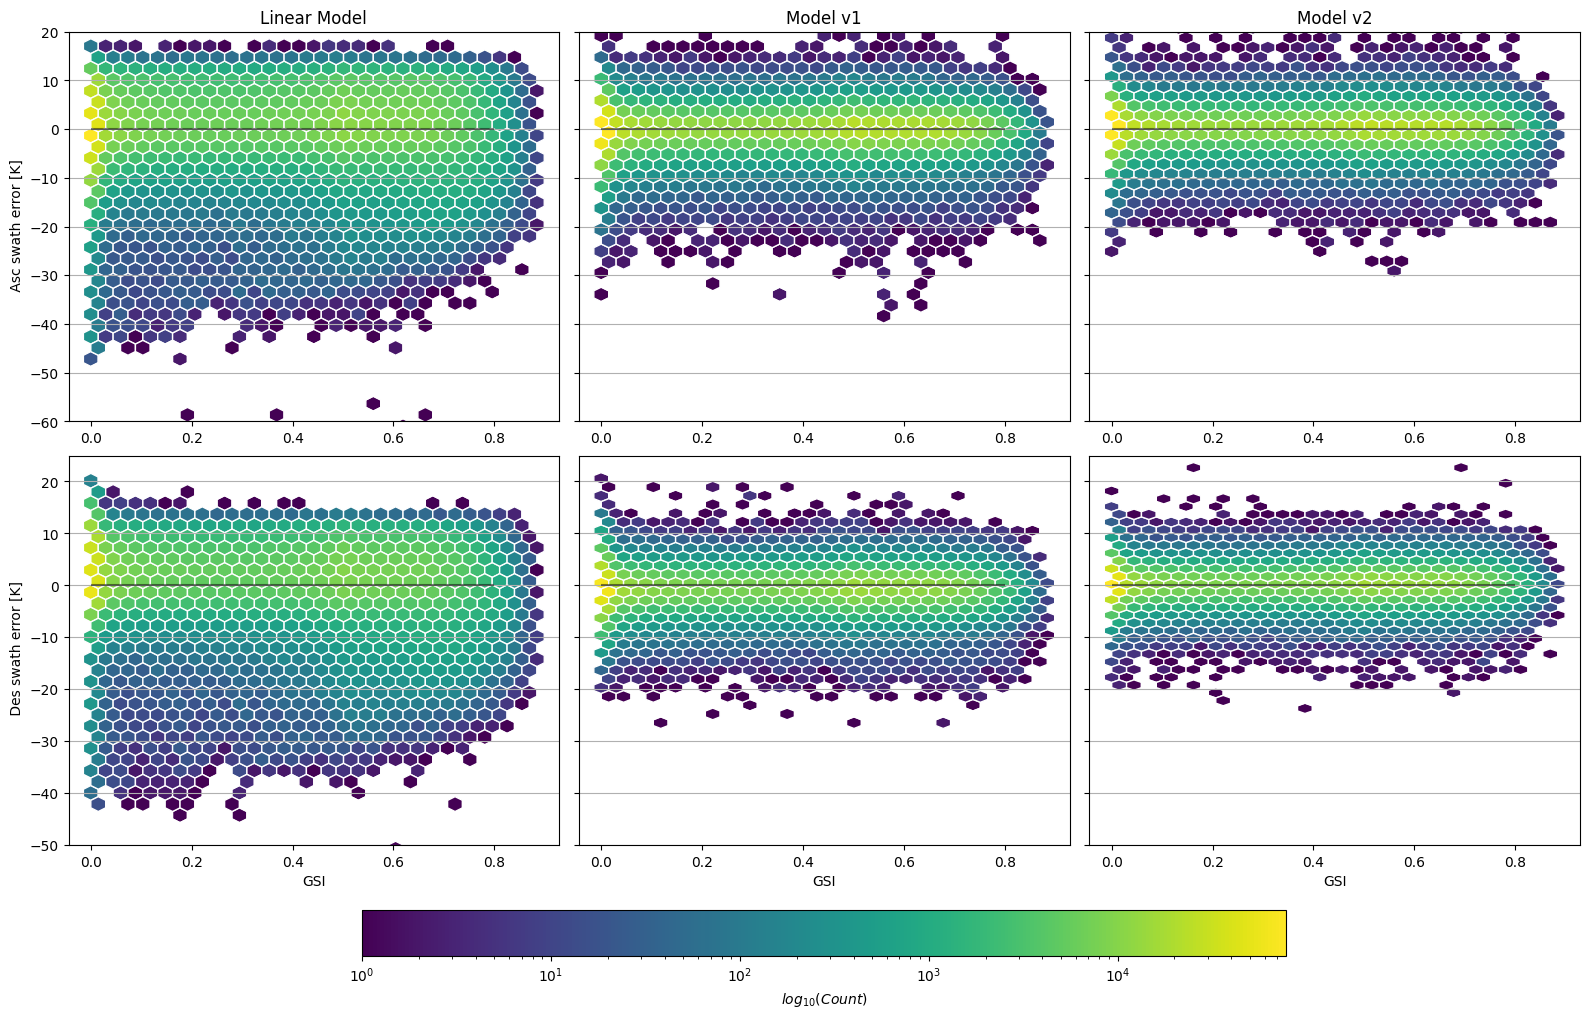

In [67]:
plot_size = 4

hexbinnorm = LogNorm()
hexbin_kw = {
    "gridsize": 30,
    "edgecolors": "white",
    "norm": hexbinnorm
}

fig, axs = plt.subplots(2, 3, figsize=(int(4 * plot_size), int(3 * plot_size)))

titles = {
    0: "Linear Model",
    1: "Model v1",
    2: "Model v2"
}

ylims = {
    0: [-60, 20],
    1: [-50, 25]
}

for i, swath_errors_df in enumerate(swath_error_list):
    for j, dvar in enumerate(["linear_error", "errorv1", "errorv2"]):
        ax = axs[i, j]
        hb = ax.hexbin(y=swath_errors_df[dvar], x=swath_errors_df["GSI"], **hexbin_kw)

        if i == 0:
            ax.set_title(titles[j])
        else:
            ax.set_xlabel("GSI")

        if j == 0:
            ax.set_ylabel(f" {swath2name[i]} swath error [K]")
        else:
            ax.set_yticklabels([])  # Remove Y tick labels for plots not in the leftmost column

        # Set the same y limits for each row
        ax.set_ylim(ylims[i])
        ax.grid(axis="y")
        ax.hlines(y = 0, xmax=0.8, xmin=0, colors="Black", alpha = 0.5)

# Adjust layout for colorbar
fig.tight_layout(rect=[0, 0.1, 1, 0.95])  # Leave space at the bottom for the colorbar

# Place the colorbar below the subplots
cbar = fig.colorbar(ScalarMappable(norm=hexbinnorm, cmap=hb.get_cmap()), 
                    ax=axs, orientation='horizontal', label='$log_{10}(Count)$',
                    fraction=0.05, pad=0.07)

plt.show()
